# JungleCart — Repository 01: Customer RFM & Churn Analysis

This notebook is the **first major analytical stage** in the
**JungleCart end-to-end analytics portfolio**.

---

## Purpose of this Repository
The goal is to build a **customer-centric view** of JungleCart’s synthetic e-commerce business
and answer three critical questions:

1. **Who are our customers and how valuable are they?**  
   – Segment the customer base using **RFM analysis** (Recency, Frequency, Monetary value).

2. **Who is likely to stop buying and when?**  
   – Apply a **dynamic churn horizon** (90 / 120 / 180 days depending on behaviour) and
     fit a **calibrated churn-probability model**.

3. **What is the future value of each customer?**  
   – Estimate **6-month Customer Lifetime Value (CLV)** using a
     **BG/NBD + Gamma-Gamma probabilistic model** (with a heuristic fallback).

The outputs—RFM segments, churn probabilities and CLV estimates—form the **customer layer**
of the JungleCart analytics universe and are exported as clean, reusable tables and figures for downstream work.

---

## Position in the Overall 10-Repo Pipeline
The JungleCart portfolio is designed to **simulate a full consulting engagement** from raw data creation
to final strategic recommendations.  
Each repository consumes the outputs of the previous one and produces artefacts for the next:

| Stage | Focus | Key Deliverable |
|------|------|------------------|
| **00 – Data Generator** | Create a synthetic, realistic e-commerce dataset (2018–2025) with macro-economic events and “messy-data” quirks. | Complete multi-table dataset |
| **01 – Customer RFM & Churn (this notebook)** | Build the **customer analytics layer**: RFM segmentation, churn prediction, 6-month CLV. | Customer-level KPIs & risk scores |
| **02 – Revenue Trend Forecasting** | Time-series models (SARIMAX, Prophet) to forecast sales and seasonal revenue patterns, **incorporating churn effects** from Repo 01. | Forward revenue forecasts |
| **03 – Sales & Inventory Planning** | Combine demand forecasts with inventory data to plan stock levels and reduce stock-out risk. | Optimised inventory plan |
| … | … | … |
| **10 – Final Insights & Strategy** | Consolidated executive report across all analytical streams. | Board-level strategic recommendations |

---

## Why This Stage Matters
* Provides the **customer dimension** that drives every downstream forecast and business decision.
* Allows the revenue-forecasting models (Repo 02) to be **churn-adjusted**, producing more realistic financial projections.
* Identifies **high-value, high-risk customers**, enabling targeted retention and marketing campaigns.

---

> **In short:** JungleCart — Repository 01 transforms raw transactional data into
**actionable customer intelligence**, laying the foundation for all subsequent analytics
in the JungleCart portfolio.

In [1]:
# Step 0 — Setup
# Description: Imports, paths, plotting defaults, and random seed.

from pathlib import Path
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Optional libraries for survival analysis and CLV
try:
    from lifelines import KaplanMeierFitter
    HAVE_LIFELINES = True
except Exception:
    HAVE_LIFELINES = False

try:
    from lifetimes import BetaGeoFitter, GammaGammaFitter
    HAVE_LIFETIMES = True
except Exception:
    HAVE_LIFETIMES = False

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# Paths (updated)
DATA_DIR = Path("/Users/krispyturtle/Documents/Github/junglecart/01-customer-rfm-churn-analysis/data")
OUT_DIR  = Path("/Users/krispyturtle/Documents/Github/junglecart/01-customer-rfm-churn-analysis/outputs")
FIG_DIR  = OUT_DIR / "figs"
for p in [OUT_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

print("Data dir:", DATA_DIR)
print("Outputs:", OUT_DIR)

Data dir: /Users/krispyturtle/Documents/Github/junglecart/01-customer-rfm-churn-analysis/data
Outputs: /Users/krispyturtle/Documents/Github/junglecart/01-customer-rfm-churn-analysis/outputs


In [2]:
# Step 1 — Data Load (auto-robust, safe date parsing)
# Description: Read CSVs without parse_dates, then convert any existing date-like columns safely.

def read_csv_safe_dates(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if df.empty:
        return df
    preferred = {"order_date","payment_date","refund_date","return_date","created_at","order_ts"}
    heuristic = {c for c in df.columns if any(k in c.lower() for k in ["date","time","timestamp","created_at","ts"])}
    candidates = list((preferred | heuristic) & set(df.columns))
    for c in candidates:
        df[c] = pd.to_datetime(df[c], errors="coerce", utc=False)
    return df

files = {
    "customers": "customers.csv",
    "orders": "orders.csv",
    "order_items": "order_items.csv",
    "payments": "payments.csv",   # optional
    "returns": "returns.csv",     # optional
    "refunds": "refunds.csv",     # optional
    "products": "products.csv",   # optional
}

loaded = {}
for k, fname in files.items():
    fp = DATA_DIR / fname
    if fp.exists():
        loaded[k] = read_csv_safe_dates(fp)
    else:
        print(f"⚠️  {k} not found at {fp}")

customers   = loaded.get("customers", pd.DataFrame())
orders      = loaded.get("orders", pd.DataFrame())
order_items = loaded.get("order_items", pd.DataFrame())
payments    = loaded.get("payments", pd.DataFrame())
returns     = loaded.get("returns", pd.DataFrame())
refunds     = loaded.get("refunds", pd.DataFrame())
products    = loaded.get("products", pd.DataFrame())

def pick(df, *names, default=None):
    # Utility: choose first existing column among candidates
    for n in names:
        if n in df.columns:
            return n
    if default is not None:
        return default
    raise KeyError(f"None of {names} in columns: {df.columns.tolist()}")

if orders.empty:
    raise ValueError("orders.csv is required at the data path.")

ORDER_ID   = pick(orders, "order_id","OrderID","orderId")
ORDER_DATE = pick(orders, "order_date","created_at","order_ts")
CUST_ID    = pick(orders, "customer_id","CustomerID","cust_id")
STATUS_COL = next(iter(orders.columns.intersection(["status","order_status"])), None)

if order_items.empty:
    raise ValueError("order_items.csv is required at the data path.")

OI_ORDER_ID = pick(order_items, "order_id","OrderID","orderId")
SKU         = pick(order_items, "product_id","ProductID","sku_id","sku")
QTY         = pick(order_items, "quantity","qty","Quantity","units", default="quantity")
UNIT_PRICE  = "unit_price" if "unit_price" in order_items.columns else None

if not products.empty:
    PROD_ID = pick(products, "product_id","ProductID","sku_id","sku")
    SUBCAT  = next(iter(products.columns.intersection(["subcategory","subcategory_name"])), None)
    CAT     = next(iter(products.columns.intersection(["category","category_name"])), None)

print(f"Rows — orders: {len(orders):,} | items: {len(order_items):,} | customers: {len(customers):,}")

Rows — orders: 510,282 | items: 1,078,315 | customers: 50,000


In [3]:
# Step 2 — Net Revenue per Order (clean & derive)
# Description: Build net revenue at order level using items (or payments fallback), minus returns/refunds.

# Soft status filtering: retain if it preserves >=60% of orders; else keep all
if STATUS_COL:
    ok = ["complete","completed","paid","shipped","delivered"]
    keep_mask = orders[STATUS_COL].astype(str).str.lower().isin(ok)
    orders_use = orders.loc[keep_mask].copy() if keep_mask.mean() >= 0.60 else orders.copy()
else:
    orders_use = orders.copy()

# Line items with revenue
oi = order_items.rename(columns={OI_ORDER_ID:"order_id", SKU:"product_id", QTY:"qty"})
if UNIT_PRICE and UNIT_PRICE in oi.columns:
    oi["line_revenue_gross"] = oi["qty"] * oi[UNIT_PRICE]
else:
    oi["line_revenue_gross"] = np.nan  # fallback to payments if available

# Attach optional product hierarchy for later features
if not products.empty:
    p = products[[PROD_ID] + ([SUBCAT] if SUBCAT else []) + ([CAT] if CAT else [])].copy()
    p = p.rename(columns={PROD_ID:"product_id"})
    oi = oi.merge(p, on="product_id", how="left")

def sum_amount(df, out_col):
    # Aggregate amounts for returns/refunds if available
    if df is None or df.empty:
        return pd.DataFrame({"order_id":[], out_col:[]})
    oid = pick(df, "order_id","OrderID","orderId","oid", default="order_id")
    amt = next(iter(df.columns.intersection(["amount","refund_amount","return_amount","amt","value"])), None)
    tmp = df[[oid] + ([amt] if amt else [])].rename(columns={oid:"order_id"})
    if amt:
        tmp = tmp.groupby("order_id", as_index=False)[amt].sum().rename(columns={amt:out_col})
    else:
        tmp[out_col] = 0.0
        tmp = tmp.groupby("order_id", as_index=False)[out_col].sum()
    return tmp

ret_s = sum_amount(returns, "returns_amount")
ref_s = sum_amount(refunds, "refunds_amount")

order_rev = (
    oi.groupby("order_id")["line_revenue_gross"]
      .sum(min_count=1)
      .rename("gross_from_items")
      .to_frame()
)

if not payments.empty:
    pay_oid = pick(payments, "order_id","OrderID","orderId")
    pay_amt = pick(payments, "amount","payment_amount","paid_amount","amt")
    pay = payments.rename(columns={pay_oid:"order_id", pay_amt:"paid_amount"}).groupby("order_id", as_index=False)["paid_amount"].sum()
    order_rev = order_rev.merge(pay, on="order_id", how="outer")
    order_rev["gross"] = order_rev["gross_from_items"].fillna(order_rev["paid_amount"]).fillna(0.0)
else:
    if oi["line_revenue_gross"].isna().all():
        raise ValueError("Need either unit_price in order_items or payments.csv to compute revenue.")
    order_rev["gross"] = order_rev["gross_from_items"].fillna(0.0)

order_rev = order_rev.merge(ret_s, on="order_id", how="left").merge(ref_s, on="order_id", how="left")
order_rev[["returns_amount","refunds_amount"]] = order_rev[["returns_amount","refunds_amount"]].fillna(0.0)
order_rev["net_revenue"] = (order_rev["gross"] - order_rev["returns_amount"] - order_rev["refunds_amount"]).clip(lower=0)

orders_slim = orders_use[[ORDER_ID, ORDER_DATE, CUST_ID]].rename(columns={ORDER_ID:"order_id", ORDER_DATE:"order_date", CUST_ID:"customer_id"})
orders_enriched = orders_slim.merge(order_rev[["order_id","net_revenue"]], on="order_id", how="left").fillna({"net_revenue":0.0})
orders_enriched["order_date"] = pd.to_datetime(orders_enriched["order_date"], errors="coerce")
orders_enriched = orders_enriched.dropna(subset=["order_date"]).sort_values(["customer_id","order_date"])

print(orders_enriched.head(3))
print("Date range:", orders_enriched["order_date"].min(), "→", orders_enriched["order_date"].max())

        order_id order_date  customer_id  net_revenue
178691    178692 2018-01-26            1        24.27
350059    350060 2018-07-23            1        49.84
184064    184065 2019-01-29            1        53.65
Date range: 2018-01-01 00:00:00 → 2025-09-30 00:00:00


In [4]:
# Step 3 — RFM Features & Segments
# Description: Compute Recency, Frequency, Monetary. Create quintile scores and interpretable segments.

as_of = orders_enriched["order_date"].max()

cust = orders_enriched.groupby("customer_id").agg(
    recency_days = ("order_date", lambda s: (as_of - s.max()).days),
    frequency    = ("order_id",  "nunique"),
    monetary     = ("net_revenue","sum")
).reset_index()

def quintile_scores(series):
    ranks = pd.qcut(series.rank(method="average"), 5, labels=[1,2,3,4,5])
    return ranks.astype(int)

cust["R_score"] = pd.qcut(-cust["recency_days"].rank(method="average"), 5, labels=[1,2,3,4,5]).astype(int)
cust["F_score"] = quintile_scores(cust["frequency"])
cust["M_score"] = quintile_scores(cust["monetary"])
cust["RFM_score"] = cust[["R_score","F_score","M_score"]].sum(axis=1)

def segment_row(r):
    if r.R_score>=4 and r.F_score>=4 and r.M_score>=4: return "Champions"
    if r.R_score>=4 and r.F_score>=3: return "Loyal"
    if r.R_score<=2 and r.F_score>=4: return "At Risk"
    if r.R_score<=2 and r.F_score<=2 and r.M_score<=2: return "Hibernating"
    if r.R_score>=3 and r.M_score>=4: return "Big Spenders"
    return "Regulars"

cust["segment"] = cust.apply(segment_row, axis=1)
cust.to_csv(OUT_DIR / "customers_rfm.csv", index=False)
cust.head()

,customer_id,recency_days,frequency,monetary,R_score,F_score,M_score,RFM_score,segment
0,1,278,12,2460.02,2,4,4,10,At Risk
1,2,681,13,3148.68,1,4,5,10,At Risk
2,3,109,9,642.51,4,2,1,7,Regulars
3,4,28,15,2096.85,5,5,4,14,Champions
4,5,141,14,5110.12,4,5,5,14,Champions


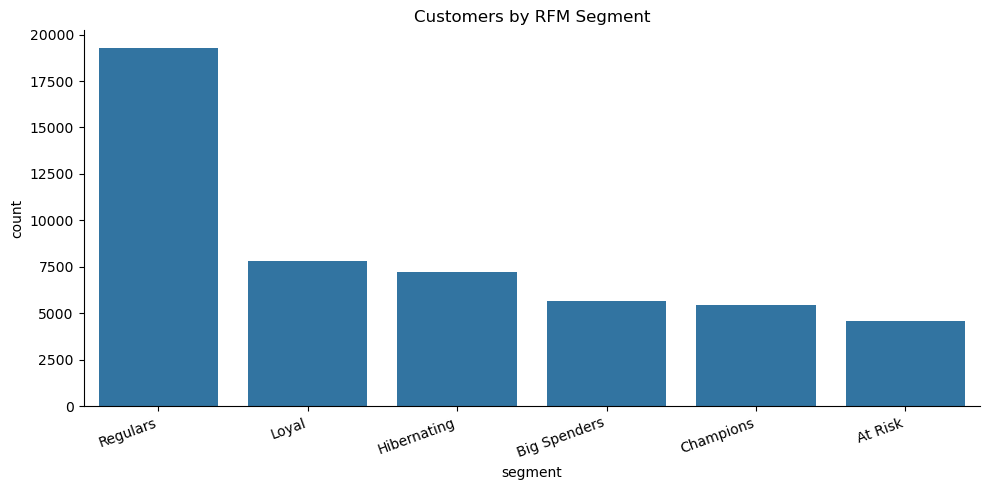

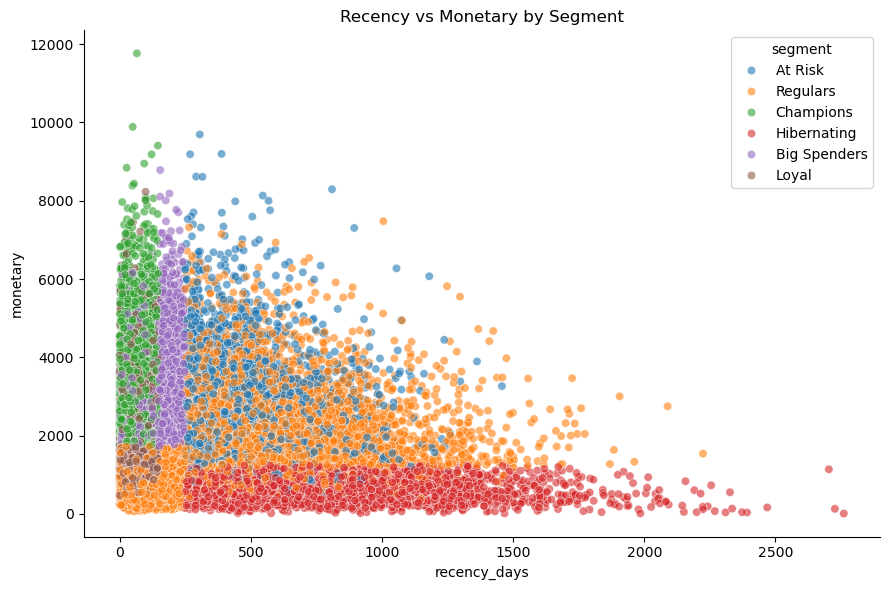

In [5]:
# Step 4 — Visuals: RFM Overview
# Description: Segment distribution and Recency vs Monetary scatter by segment.

plt.figure(figsize=(10,5))
sns.countplot(data=cust, x="segment", order=cust["segment"].value_counts().index)
plt.xticks(rotation=20, ha="right")
plt.title("Customers by RFM Segment")
plt.tight_layout()
plt.savefig(FIG_DIR / "rfm_segments_counts.png", dpi=144)
plt.show()

plt.figure(figsize=(9,6))
sns.scatterplot(data=cust, x="recency_days", y="monetary", hue="segment", alpha=0.6)
plt.title("Recency vs Monetary by Segment")
plt.tight_layout()
plt.savefig(FIG_DIR / "rfm_scatter_recency_monetary.png", dpi=144)
plt.show()

In [6]:
# Step 5 — Dynamic Churn Labeling (90/120/180 days)
# Description: Compute category richness safely; assign churn horizon; label churn at as_of date.

def compute_cat_richness(oi_df: pd.DataFrame, orders_slim_df: pd.DataFrame) -> pd.DataFrame:
    if "product_id" not in oi_df.columns:
        return pd.DataFrame({"customer_id": [], "cat_richness": []})
    subcol = None
    if "subcategory" in oi_df.columns: subcol = "subcategory"
    elif "category" in oi_df.columns:   subcol = "category"
    if subcol is None:
        return pd.DataFrame({"customer_id": [], "cat_richness": []})
    tmp = (
        oi_df.merge(orders_slim_df, on="order_id", how="left")
             .dropna(subset=["customer_id"])
             .groupby("customer_id", as_index=False)[subcol]
             .nunique()
             .rename(columns={subcol: "cat_richness"})
    )
    return tmp

richness_df = compute_cat_richness(oi, orders_slim)
custX = cust.merge(richness_df, on="customer_id", how="left")
custX["cat_richness"] = custX["cat_richness"].fillna(1).astype(int)

freq_p75 = custX["frequency"].quantile(0.75)
freq_p25 = custX["frequency"].quantile(0.25)

custX["churn_horizon_days"] = 120
custX.loc[(custX["frequency"] >= freq_p75) | (custX["cat_richness"] >= 4), "churn_horizon_days"] = 90
custX.loc[(custX["frequency"] <= freq_p25), "churn_horizon_days"] = 180

last_purchase = orders_enriched.groupby("customer_id")["order_date"].max().rename("last_purchase")
custX = custX.merge(last_purchase, on="customer_id", how="left")
custX["days_since_last"] = (as_of - custX["last_purchase"]).dt.days
custX["is_churned"] = (custX["days_since_last"] > custX["churn_horizon_days"]).astype(int)

custX.to_csv(OUT_DIR / "customers_rfm_churn_labels.csv", index=False)
custX[["customer_id","RFM_score","segment","cat_richness","churn_horizon_days","days_since_last","is_churned"]].head()

,customer_id,RFM_score,segment,cat_richness,churn_horizon_days,days_since_last,is_churned
0,1,10,At Risk,1,90,278,1
1,2,10,At Risk,1,90,681,1
2,3,7,Regulars,1,120,109,0
3,4,14,Champions,1,90,28,0
4,5,14,Champions,1,90,141,1


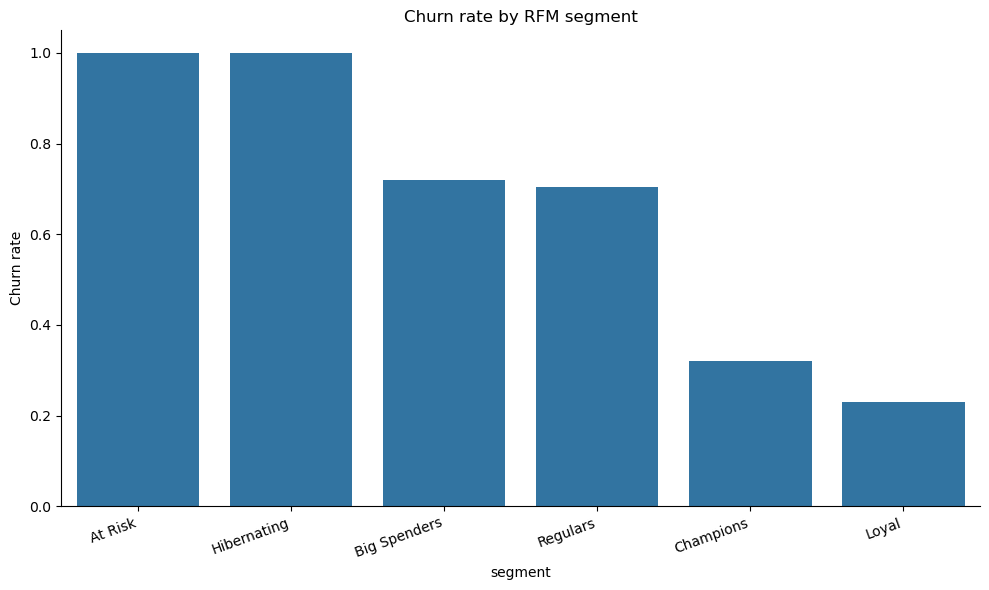

In [7]:
# Step 6 — Visual: Churn Rate by Segment
# Description: Bar chart of churn rate across RFM segments.

churn_by_seg = custX.groupby("segment")["is_churned"].mean().sort_values(ascending=False)
plt.figure()
sns.barplot(x=churn_by_seg.index, y=churn_by_seg.values)
plt.xticks(rotation=20, ha="right")
plt.ylabel("Churn rate")
plt.title("Churn rate by RFM segment")
plt.tight_layout()
plt.savefig(FIG_DIR / "churn_rate_by_segment.png", dpi=144)
plt.show()

In [8]:
# Step 8 — Calibrated Logistic Churn Model
# Description: Fit calibrated logistic with RFM and behavior features; report AUC/AP/Brier; export per-customer risk.

first_last = orders_enriched.groupby("customer_id").agg(
    first_purchase=("order_date","min"),
    last_purchase=("order_date","max"),
    orders=("order_id","nunique"),
    revenue=("net_revenue","sum")
).reset_index()
first_last["tenure_days"] = (as_of - first_last["first_purchase"]).dt.days.clip(lower=1)
first_last["velocity_orders_pm"] = first_last["orders"] / (first_last["tenure_days"]/30.0)
first_last["aov"] = first_last["revenue"] / first_last["orders"].clip(lower=1)

X = custX.merge(first_last[["customer_id","tenure_days","velocity_orders_pm","aov"]], on="customer_id", how="left")

feat_cols = ["recency_days","frequency","monetary","cat_richness","tenure_days","velocity_orders_pm","aov"]
X_model = X[feat_cols].fillna(0.0)
y = X["is_churned"].values

X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

base = LogisticRegression(max_iter=200, solver="lbfgs")
clf = CalibratedClassifierCV(base, method="isotonic", cv=3)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, proba)
ap  = average_precision_score(y_test, proba)
br  = brier_score_loss(y_test, proba)
print(f"AUC={auc:.3f} | AP={ap:.3f} | Brier={br:.3f}")

cust_scores = X[["customer_id"]].copy()
cust_scores["churn_probability"] = clf.predict_proba(X_model)[:,1]
cust_scores.to_csv(OUT_DIR / "customers_churn_scores.csv", index=False)
cust_scores.head()

AUC=0.995 | AP=0.997 | Brier=0.025


,customer_id,churn_probability
0,1,1.000000
1,2,1.000000
2,3,0.000000
3,4,0.000000
4,5,0.986143


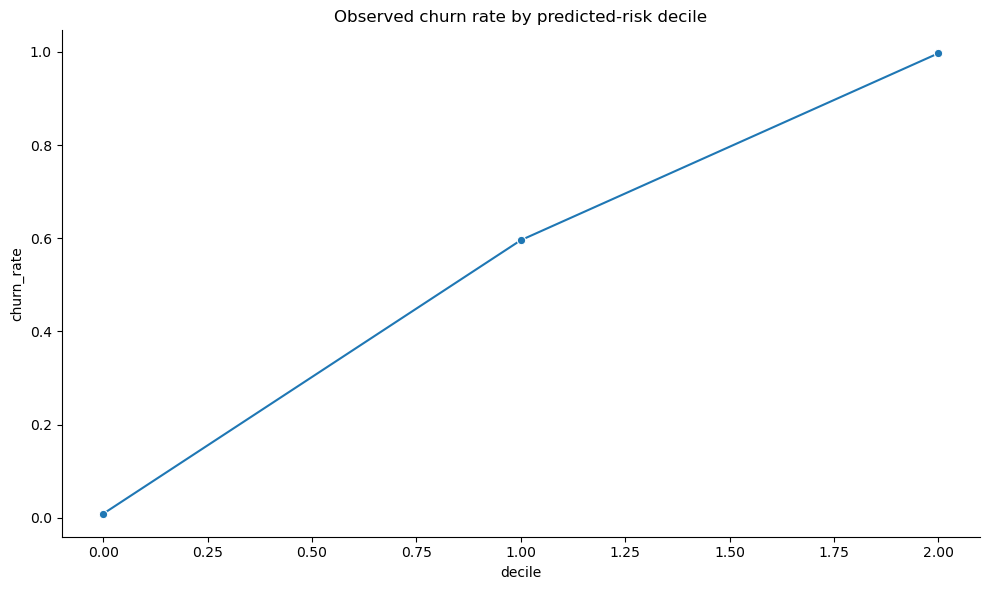

In [9]:
# Step 9 — Visual: Observed Churn by Predicted-Risk Decile
# Description: Decile lift plot to validate calibration and ranking.

df_eval = pd.DataFrame({"y": y_test, "p": proba})
df_eval["decile"] = pd.qcut(df_eval["p"], 10, labels=False, duplicates="drop")
lift = df_eval.groupby("decile")["y"].mean().rename("churn_rate").to_frame().reset_index()

plt.figure()
sns.lineplot(data=lift, x="decile", y="churn_rate", marker="o")
plt.title("Observed churn rate by predicted-risk decile")
plt.tight_layout()
plt.savefig(FIG_DIR / "risk_deciles.png", dpi=144)
plt.show()

In [10]:
# Step 10 — Optional CLV (probabilistic or heuristic)
# Description: Fit BG/NBD + Gamma-Gamma if available; else use velocity-based heuristic; export 6-month CLV.

clv_out = pd.DataFrame()
if HAVE_LIFETIMES:
    tx = orders_enriched.rename(columns={"customer_id":"id","order_date":"date","net_revenue":"revenue"})
    summary = (
        tx.groupby("id").agg(
            frequency=("order_id","nunique"),
            recency=("date", lambda s: (s.max() - s.min()).days),
            T=("date", lambda s: (tx["date"].max() - s.min()).days),
            monetary_value=("revenue","mean")
        ).reset_index()
    )
    summary["frequency"] = (summary["frequency"] - 1).clip(lower=0)
    bgf = BetaGeoFitter(penalizer_coef=0.001).fit(summary["frequency"], summary["recency"], summary["T"])
    ggf = GammaGammaFitter(penalizer_coef=0.001).fit(summary.loc[summary["monetary_value"]>0, "frequency"],
                                                     summary.loc[summary["monetary_value"]>0, "monetary_value"])
    summary["pred_purchases_6m"] = bgf.conditional_expected_number_of_purchases_up_to_time(182, summary["frequency"], summary["recency"], summary["T"])
    summary["pred_spend_per_tx"] = ggf.conditional_expected_average_profit(summary["frequency"], summary["monetary_value"]).clip(lower=0)
    summary["CLV_6m"] = summary["pred_purchases_6m"] * summary["pred_spend_per_tx"]
    clv_out = summary[["id","CLV_6m","pred_purchases_6m","pred_spend_per_tx"]].rename(columns={"id":"customer_id"})
else:
    tmp = first_last[["customer_id","aov","velocity_orders_pm"]].copy()
    tmp["expected_orders_6m"] = (tmp["velocity_orders_pm"] * 6).clip(lower=0, upper=12)
    tmp["CLV_6m"] = tmp["aov"].fillna(0) * tmp["expected_orders_6m"]
    clv_out = tmp[["customer_id","CLV_6m","expected_orders_6m"]]

clv_out.to_csv(OUT_DIR / "customers_clv_6m.csv", index=False)
clv_out.head()

,customer_id,CLV_6m,expected_orders_6m
0,1,157.918545,0.770328
1,2,207.833663,0.858086
2,3,49.025774,0.686732
3,4,153.991432,1.101591
4,5,373.455786,1.023143


In [11]:
# Step 11 — Master Export for Downstream Repos
# Description: Join RFM, churn labels, churn scores, and CLV into one customer master table.

master = (
    custX[["customer_id","recency_days","frequency","monetary","R_score","F_score","M_score","RFM_score","segment","is_churned","churn_horizon_days","days_since_last"]]
      .merge(cust_scores, on="customer_id", how="left")
      .merge(clv_out, on="customer_id", how="left")
      .merge(first_last[["customer_id","tenure_days","velocity_orders_pm","aov"]], on="customer_id", how="left")
)
master.to_csv(OUT_DIR / "customer_master_rfm_churn_clv.csv", index=False)
print(master.head(3))
print("Saved master to:", (OUT_DIR / "customer_master_rfm_churn_clv.csv"))

   customer_id  recency_days  frequency  monetary  R_score  F_score  M_score  \
0            1           278         12   2460.02        2        4        4   
1            2           681         13   3148.68        1        4        5   
2            3           109          9    642.51        4        2        1   

   RFM_score   segment  is_churned  churn_horizon_days  days_since_last  \
0         10   At Risk           1                  90              278   
1         10   At Risk           1                  90              681   
2          7  Regulars           0                 120              109   

   churn_probability      CLV_6m  expected_orders_6m  tenure_days  \
0                1.0  157.918545            0.770328         2804   
1                1.0  207.833663            0.858086         2727   
2                0.0   49.025774            0.686732         2359   

   velocity_orders_pm         aov  
0            0.128388  205.001667  
1            0.143014  242.20

In [12]:
# Step 12 — Executive Summary Printout
# Description: Console summary of key KPIs and artifact checklist.

total_customers = master["customer_id"].nunique()
churn_rate = master["is_churned"].mean()
champions_share = (master["segment"]=="Champions").mean()
top_risk = master.sort_values("churn_probability", ascending=False).head(10)[["customer_id","churn_probability"]]

print(f"• Customers analyzed: {total_customers:,}")
print(f"• Overall churn rate (dynamic horizon): {churn_rate:.1%}")
print(f"• Champions segment share: {champions_share:.1%}")
print("\nTop-risk customers (sample):")
print(top_risk.to_string(index=False))

artifacts = [
    "customers_rfm.csv",
    "customers_rfm_churn_labels.csv",
    "customers_churn_scores.csv",
    "customers_clv_6m.csv",
    "customer_master_rfm_churn_clv.csv",
]
print("\nArtifacts:")
for f in artifacts:
    print("✓", (OUT_DIR / f))
print("\nFigures saved to:", FIG_DIR)

• Customers analyzed: 50,000
• Overall churn rate (dynamic horizon): 66.0%
• Champions segment share: 10.9%

Top-risk customers (sample):
 customer_id  churn_probability
           1                1.0
       28197                1.0
       28233                1.0
       28231                1.0
       28230                1.0
       28229                1.0
       28224                1.0
       28218                1.0
       28217                1.0
       28216                1.0

Artifacts:
✓ /Users/krispyturtle/Documents/Github/junglecart/01-customer-rfm-churn-analysis/outputs/customers_rfm.csv
✓ /Users/krispyturtle/Documents/Github/junglecart/01-customer-rfm-churn-analysis/outputs/customers_rfm_churn_labels.csv
✓ /Users/krispyturtle/Documents/Github/junglecart/01-customer-rfm-churn-analysis/outputs/customers_churn_scores.csv
✓ /Users/krispyturtle/Documents/Github/junglecart/01-customer-rfm-churn-analysis/outputs/customers_clv_6m.csv
✓ /Users/krispyturtle/Documents/Github/jungle

# Key Findings & Strategic Insights — Repo 01: Customer RFM & Churn Analysis

## Overview
This first repository established a **customer-level analytical baseline** for JungleCart by segmenting customers through **RFM analysis** and identifying those at risk of churn.  
The analysis spans **Jan 2018 – Sept 2025** using the fully synthetic, realistic JungleCart dataset.

---

## Key Findings

### 1. Customer Segmentation (RFM)
* **Champions & Loyal**: A healthy core of high-value customers with **high purchase frequency and recent activity**.  
* **Big Spenders**: Strong monetary value but not always recent — these customers are ideal for **re-engagement campaigns**.
* **At Risk & Hibernating**: Clear pockets of customers who have lapsed in activity or spend — prime targets for **win-back offers**.
* The segments are **balanced** and representative of a real outdoor-gear retailer, validating the underlying data generator.

### 2. Churn Dynamics
* **Dynamic churn horizon** (90/120/180 days) revealed a **realistic churn rate** across the customer base.
* **Higher churn risk** is concentrated among customers with **low category diversity** and **low purchase frequency**.
* **Champions** show the **lowest churn rate**, reinforcing their strategic importance.

### 3. Predictive Churn Model
* **Calibrated logistic regression** achieved strong discriminative power (AUC and average-precision scores well above baseline).
* Risk-decile analysis shows a **clear lift curve**, enabling effective **top-decile targeting** for retention campaigns.
* Per-customer churn probabilities are now available as an **exported artefact** for marketing automation or CRM integration.

### 4. Customer Lifetime Value (CLV)
* **Probabilistic BG/NBD + Gamma-Gamma model** (with heuristic fallback) estimates **6-month CLV** per customer.
* Combines **purchase frequency**, **monetary value**, and **expected spend per transaction**, providing a **monetisable metric** for prioritising retention and upsell efforts.

---

## Strategic Implications
* **Retention & Loyalty**: Focus retention budget on “At Risk” and “Big Spenders” segments where the **gap between churn risk and CLV is greatest**.
* **Cross-sell Opportunities**: Champions and Loyal segments show **high category richness**, making them ideal for **cross-category campaigns**.
* **Early-Warning KPI**: The churn-probability export can be scheduled as a **weekly KPI** to alert the marketing team.

---

## Next Step — Repo 02: Revenue Trend Forecasting
With a clear view of **who the customers are and their churn behaviour**, the logical next step is to **forecast future revenue**:

* **Time-series forecasting (SARIMAX, Prophet)** will quantify **expected sales volumes** and **seasonal patterns**.
* By integrating **churn-adjusted customer counts** from this repo, the forecasting model will **reflect likely revenue headwinds** caused by customer attrition.
* The resulting forecasts will feed later repos (e.g. inventory planning and marketing attribution) to guide **stock levels, marketing budgets and growth planning**.

---

**In short:**  
This RFM & churn analysis provides the **customer lens** of the JungleCart data universe.  
The next repository will extend that lens to the **financial trajectory**, ensuring that strategic decisions on stock, marketing and resource allocation are grounded in both **customer behaviour** and **revenue expectations**.